# <center>Mobile Games: A/B Testing & Player Retention </center> 

## Table of Contents

1. **[Project Background](#1)**
2. **[Data Loading and Cleaning](#2)**
3. **[EDA ](#3)**
4. **[ A/B Test ](#4)<br>**
   4.1[ Z-test with formula ](#4.1)<br>
   4.2[ Z-test with statsmodels.api ](#4.2)<br>
   4.3[ BootStrapping ](#4.3)<br>
5. **[Conclusion](#5)**

## 1. Project Background <a name= '1'></a>

<p><a href="https://www.facebook.com/cookiecatsgame">Cookie Cats</a> is a hugely popular mobile puzzle game developed by <a href="http://tactile.dk">Tactile Entertainment</a>. It's a classic "connect three"-style puzzle game where the player must connect tiles of the same color to clear the board and win the level. It also features singing cats. Check out this short demo:</p>
<p><a href="https://youtu.be/GaP5f0jVTWE"><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cookie_cats_video.jpeg" style="width: 500px"></a></p>
<p>As players progress through the levels of the game, they will <strong>occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress</strong>. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.<p>But where should the gates be placed? Initially the first gate was placed at level 30. <strong>In this project, we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention.</strong> </p>
<p><img src="https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png" alt=""></p>

## 2. Data Loading and Cleaning <a name= '2'></a>

In [1]:
#import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load data from csv
df = pd.read_csv('cookie_cats.csv')

In [3]:
#view the data
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [4]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
#check for outliers
df.describe(include = 'all')

,userid,version,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189,90189.000000,90189,90189
unique,NaN,2,NaN,2,2
top,NaN,gate_40,NaN,False,False
freq,NaN,45489,NaN,50036,73408
mean,4.998412e+06,NaN,51.872457,NaN,NaN
std,2.883286e+06,NaN,195.050858,NaN,NaN
min,1.160000e+02,NaN,0.000000,NaN,NaN
25%,2.512230e+06,NaN,5.000000,NaN,NaN
50%,4.995815e+06,NaN,16.000000,NaN,NaN
75%,7.496452e+06,NaN,51.000000,NaN,NaN


insight:std of sum_gamerounds is 195 which is too large.It means there are outliers in column'sum_gamerounds'.

<Axes: >

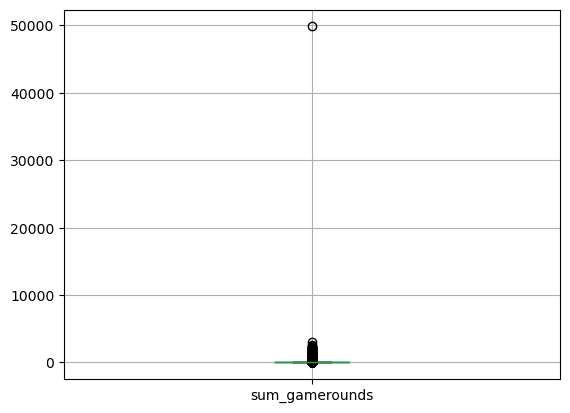

In [6]:
#visualize df['sum_gamerounds'] to see the outliers
df.boxplot(column = ['sum_gamerounds'])

## 3. EDA <a name= '3'></a>

#### 3.1 Player & Gamerounds Analysis 

In [7]:
#The number of players groupby the number of gamerounds during the first week
df_gamerounds = df.groupby(['sum_gamerounds'],as_index = False).agg(cnt_users = ('userid','count')).sort_values(by = 'sum_gamerounds')
df_gamerounds

,sum_gamerounds,cnt_users
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
...,...,...
937,2294,1
938,2438,1
939,2640,1
940,2961,1


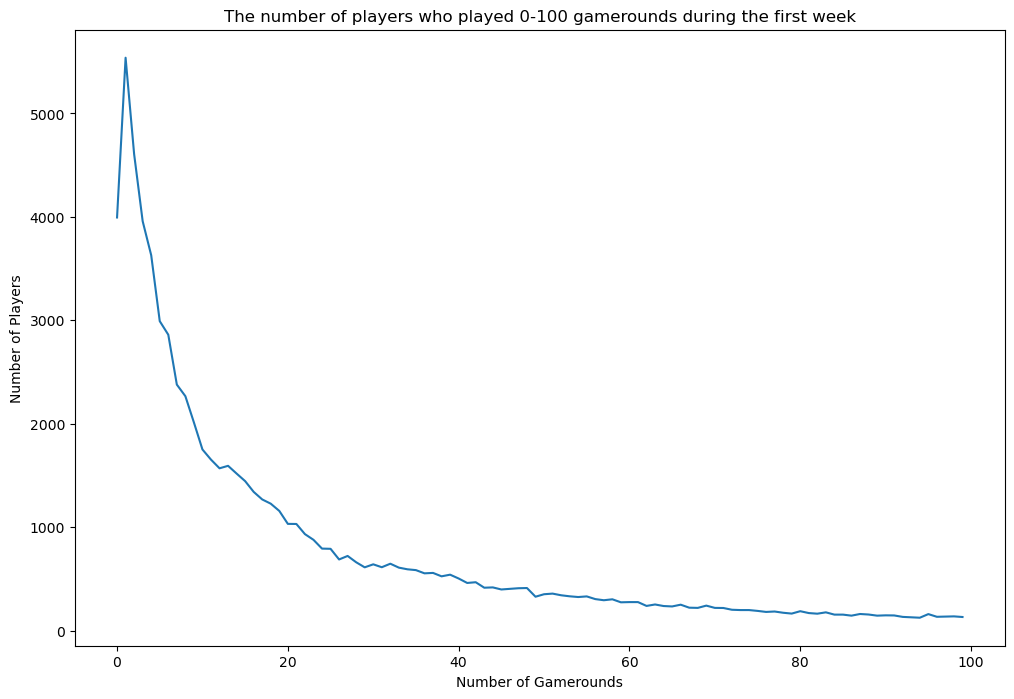

In [8]:
#Visualize the number of players who played 0-100 gamerounds during the first week
gamerounds = df_gamerounds[:100]
plt.figure(figsize=(12,8))
ax = sns.lineplot(data=gamerounds, x="sum_gamerounds", y="cnt_users")
ax.set(xlabel='Number of Gamerounds', 
          ylabel='Number of Players',
          title='The number of players who played 0-100 gamerounds during the first week')
plt.show()

In [19]:
#defining function filter 
def filter(x):
    if (x >= 0 and x <= 10):
        return 'Round:0-10'
    if (x > 10 and x <= 50):
        return 'Round:11-50'
    if (x > 50 and x <= 100):
        return 'Round:51-100'
    if x > 100:
        return 'Round:100+'
#applying the filter function to 'sum_gamerounds' column 
df_gamerounds['game_c'] = df_gamerounds['sum_gamerounds'].apply(filter)
df_gamerounds

,sum_gamerounds,cnt_users,game_c
0,0,3994,Round:0-10
1,1,5538,Round:0-10
2,2,4606,Round:0-10
3,3,3958,Round:0-10
4,4,3629,Round:0-10
...,...,...,...
937,2294,1,Round:100+
938,2438,1,Round:100+
939,2640,1,Round:100+
940,2961,1,Round:100+


In [20]:
df_c = df_gamerounds.groupby(['game_c'],as_index = False).agg(gamers = ('cnt_users','sum')).sort_values(by = 'gamers',ascending = False)

In [21]:
df_c

,game_c,gamers
0,Round:0-10,35989
2,Round:11-50,31388
1,Round:100+,12385
3,Round:51-100,10427


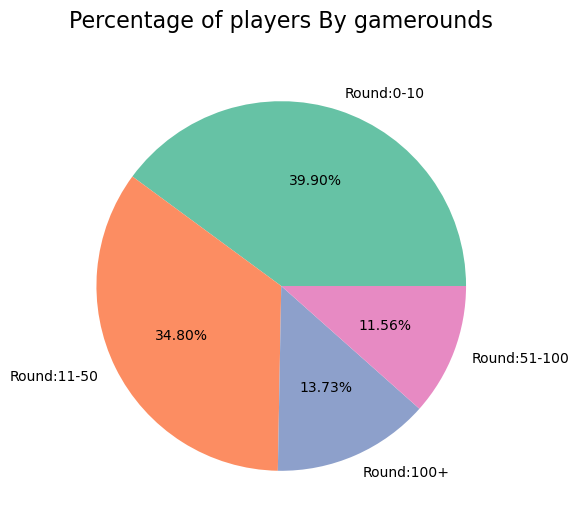

In [23]:
plt.figure(figsize=(6,6))
# create pie chart to show percentage
plt.pie(
    x=df_c['gamers'], 
    labels=df_c['game_c'],
    autopct='%1.2f%%',
    # Use Seaborn's color palette 'Set2'
    colors=sns.color_palette('Set2')
)

# Add Title 
plt.title(
    label="Percentage of players By gamerounds", 
    fontdict={"fontsize":16},
    pad=20
)

plt.show()

#### 3.2 Retition Analysis

In [24]:
df.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [27]:
df_r = (
df.groupby(['sum_gamerounds'],as_index = False)
    .agg(retention_rate1 = ('retention_1','mean'),
        retention_rate7 = ('retention_7','mean'))
)

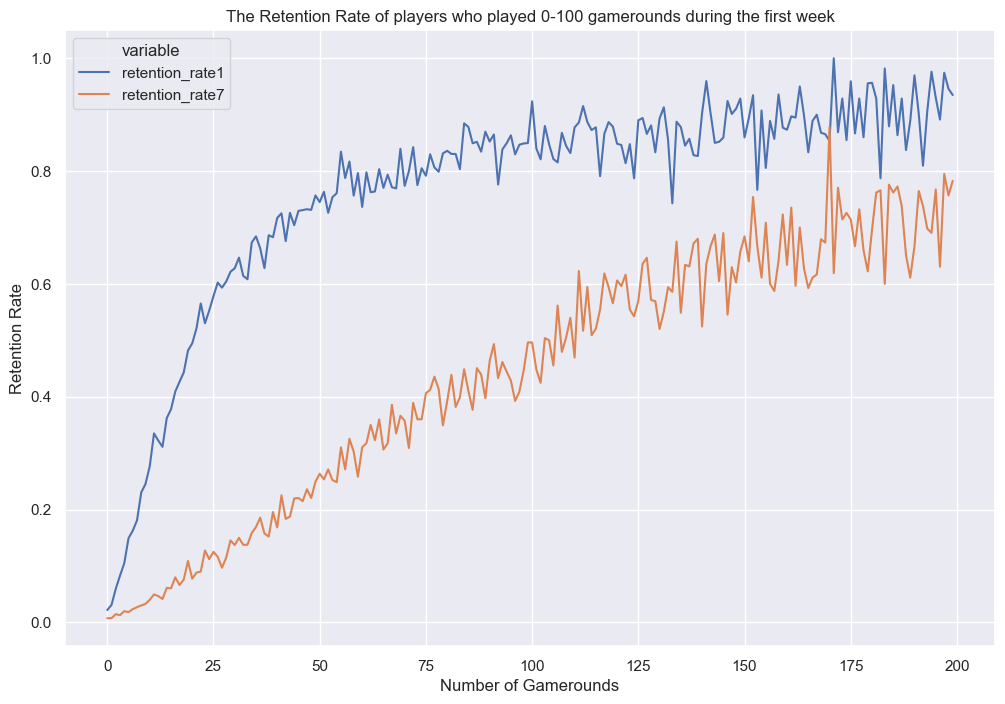

In [47]:
#Visualize retention_rate vs gamerounds
re_rate = df_r[:200]
plt.figure(figsize=(12,8))
#ax = sns.lineplot(data=re_rate, x="sum_gamerounds", y="retention_rate1")
ax = sns.lineplot(x='sum_gamerounds', y='value', hue='variable', 
             data=pd.melt(re_rate, ['sum_gamerounds']))
ax.set(xlabel='Number of Gamerounds', 
          ylabel='Retention Rate',
          title='The Retention Rate of players who played 0-100 gamerounds during the first week')
plt.show()

In [32]:
re_rate

,sum_gamerounds,retention_rate1,retention_rate7
0,0,0.021783,0.007261
1,1,0.030878,0.007403
2,2,0.059488,0.014546
3,3,0.082870,0.012633
4,4,0.104712,0.019840
...,...,...,...
95,95,0.863354,0.428571
96,96,0.829630,0.392593
97,97,0.846715,0.408759
98,98,0.848921,0.446043


In [34]:
re_rate[["sum_gamerounds","retention_rate1","retention_rate7"]].corr()

,sum_gamerounds,retention_rate1,retention_rate7
sum_gamerounds,1.000000,0.884062,0.985428
retention_rate1,0.884062,1.000000,0.878457
retention_rate7,0.985428,0.878457,1.000000


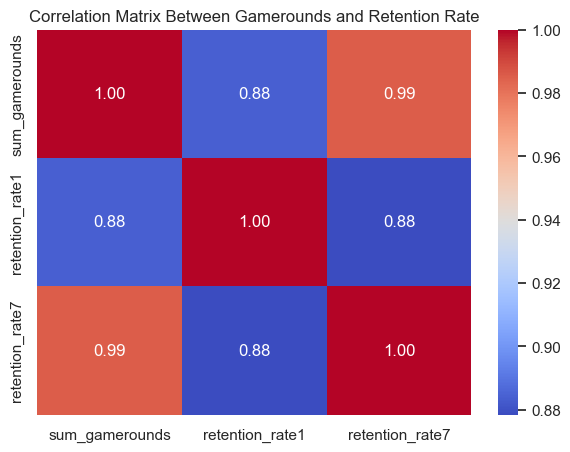

In [44]:
sns.set (rc = {'figure.figsize':(7, 5)})
plt.title('Correlation Matrix Between Gamerounds and Retention Rate')
sns.heatmap(re_rate[["sum_gamerounds","retention_rate1","retention_rate7"]].corr(), 
            annot=True, 
            fmt=".2f", 
            cmap = "coolwarm")
plt.show()

## 4. A/B Test <a name= '4'></a>

In [56]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [57]:
df_2 = (df.groupby(['version'],as_index = False)
     .agg(
      crt_players = ('userid','count'),
      retention_r1 = ('retention_1','mean'),
      retention_r7 = ('retention_7','mean'),
     )
)
df_2

,version,crt_players,retention_r1,retention_r7
0,gate_30,44700,0.448188,0.190201
1,gate_40,45489,0.442283,0.182000


#### 4.1 Z-test with formula<a name= '4.1'></a>

**4.1.1Day1-Retention Rate Comparing**<br>
Hypothesis Test:<br>
H0 :P1(retention_rate1_30) - P2(retention_rate1_40) = 0 <br>
Ha :P1(retention_rate1_30) - P2(retention_rate1_40) > 0


In [58]:
def z_test(p1,p2,n1,n2):
    p = (p1 * n1 + p2* n2)/(n1 + n2)
    delta = p1 - p2
    return delta/np.sqrt(p*(1-p)*(1/n1 + 1/n2))

In [59]:
n1 = df_2['crt_players'][0]
n2 = df_2['crt_players'][1]
p1 = df_2['retention_r1'][0]
p2 = df_2['retention_r1'][1]

z_value = z_test(p1,p2,n1,n2)
z_value

1.7840862247974725

In [60]:
from scipy.stats import norm
p_value = 1- norm.cdf(z_value)

p_value

0.03720482764845956

In [66]:
if p_value < 0.05:
    print('Because p_value < significance level, reject null hypothesis.\nA gate at level 30 has higher Retention Rate of Day1 than gate at level 40')
else:
    print('Fail to reject null hypothesis')

Because p_value < significance level, reject null hypothesis.
A gate at level 30 has higher Retention Rate of Day1 than gate at level 40


**4.1.2 Day7-Retention Rate Comparing**<br>
Hypothesis Test:<br>
H0 :P1(retention_rate7_30) - P2(retention_rate7_40) = 0 <br>
Ha :P1(retention_rate7_30) - P2(retention_rate7_40) > 0

In [61]:
n1 = df_2['crt_players'][0]
n2 = df_2['crt_players'][1]
p1 = df_2['retention_r7'][0]
p2 = df_2['retention_r7'][1]

z_value = z_test(p1,p2,n1,n2)
z_value

3.164358912748191

In [62]:
p_value = 1- norm.cdf(z_value)

p_value

0.0007771249878071318

In [67]:
if p_value < 0.05:
    print('Because p_value < significance level, reject null hypothesis.\nA gate at level 30 has higher Retention Rate of Day7 than gate at level 40')
else:
    print('Fail to reject null hypothesis')

Because p_value < significance level, reject null hypothesis.
A gate at level 30 has higher Retention Rate of Day7 than gate at level 40


#### 4.2 z_test with statsmodels.api<a name= '4.2'></a>

**4.2.1Day1-Retention Rate Comparing**<br>
Hypothesis Test:<br>
H0 :P1(retention_rate1_30) - P2(retention_rate1_40) = 0 <br>
Ha :P1(retention_rate1_30) - P2(retention_rate1_40) > 0

In [68]:
import statsmodels.api as sm

In [77]:
number_of_success = [df_2['retention_r1'][0]*df_2['crt_players'][0],
                     df_2['retention_r1'][1]*df_2['crt_players'][1]]

total_sample_size = [df_2['crt_players'][0],df_2['crt_players'][1]]


In [78]:
z_score, p_value = sm.stats.proportions_ztest \
(number_of_success, total_sample_size, alternative='larger')
print('z-score: ',z_score ,', p-value: ', p_value)

z-score:  1.7840862247974725 , p-value:  0.03720482764845957


In [79]:
if p_value < 0.05:
    print('Because p_value < significance level, reject null hypothesis.\nA gate at level 30 has higher Retention Rate of Day1 than gate at level 40')
else:
    print('Fail to reject null hypothesis')

Because p_value < significance level, reject null hypothesis.
A gate at level 30 has higher Retention Rate of Day1 than gate at level 40


**4.2.2 Day7-Retention Rate Comparing**<br>
Hypothesis Test:<br>
H0 :P1(retention_rate7_30) - P2(retention_rate7_40) = 0 <br>
Ha :P1(retention_rate7_30) - P2(retention_rate7_40) > 0

In [83]:
number_of_success = [df_2['retention_r7'][0]*df_2['crt_players'][0],
                     df_2['retention_r7'][1]*df_2['crt_players'][1]]

total_sample_size = [df_2['crt_players'][0],df_2['crt_players'][1]]

In [84]:
z_score, p_value = sm.stats.proportions_ztest \
(number_of_success, total_sample_size, alternative='larger')
print('z-score: ',z_score ,', p-value: ', p_value)

z-score:  3.164358912748191 , p-value:  0.0007771249878071645


In [85]:
if p_value < 0.05:
    print('Because p_value < significance level, reject null hypothesis.\nA gate at level 30 has higher Retention Rate of Day7 than gate at level 40')
else:
    print('Fail to reject null hypothesis')

Because p_value < significance level, reject null hypothesis.
A gate at level 30 has higher Retention Rate of Day7 than gate at level 40


#### 4.3 BootStrapping<a name= '4.3'></a>

In [88]:
(df.sample(frac = 1,replace = True).groupby(['version'],as_index = False)
     .agg(
      crt_players = ('userid','count'),
      retention_r1 = ('retention_1','mean'),
      retention_r7 = ('retention_7','mean'),
     )
 )

,version,crt_players,retention_r1,retention_r7
0,gate_30,44823,0.448721,0.194097
1,gate_40,45366,0.441873,0.185227


In [120]:
boot_1d = []
boot_7d = []
boot_1d_diff = []
boot_7d_diff = []

for i in range(1000):
    r1 = df.sample(frac = 1,replace = True).groupby(['version'])['retention_1'].mean()
    r7 = df.sample(frac = 1,replace = True).groupby(['version'])['retention_7'].mean()
    boot_1d.append(r1)
    boot_1d_diff.append((r1.gate_30 - r1.gate_40)/r1.gate_40*100)
    boot_7d.append(r7)
    boot_7d_diff.append((r7.gate_30 - r7.gate_40)/r7.gate_40*100)
    
boot_1d = pd.DataFrame(boot_1d)
boot_1d_diff = pd.DataFrame(boot_1d_diff)

boot_7d = pd.DataFrame(boot_7d)
boot_7d_diff = pd.DataFrame(boot_7d_diff)

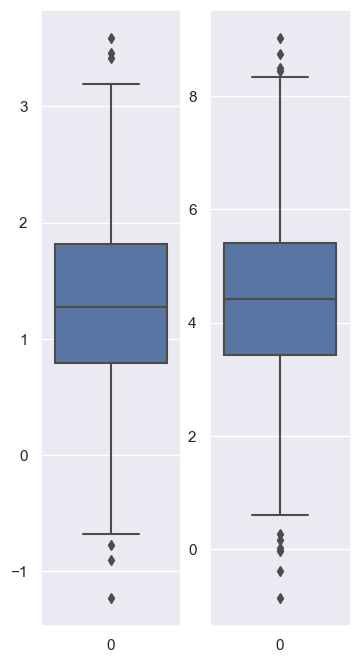

In [156]:
plt.figure(figsize=(4,8))
plt.subplot(1, 2, 1) 
sns.boxplot(boot_1d_diff)

plt.subplot(1, 2, 2) 
sns.boxplot(boot_7d_diff)
plt.show()

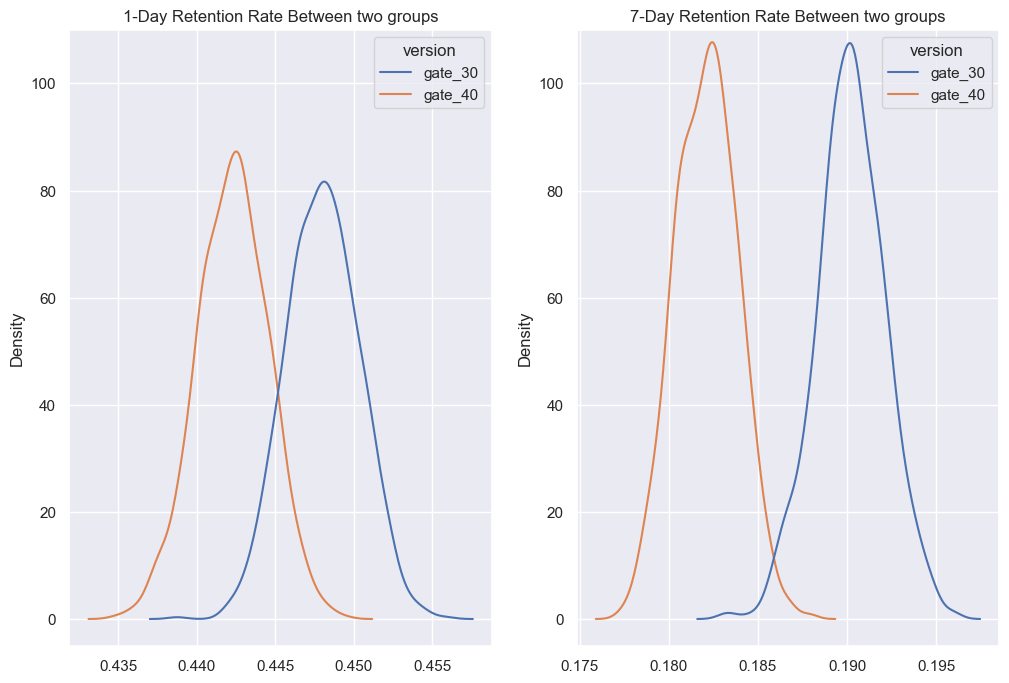

In [147]:
# A Kernel Density Estimate plot of the bootstrap distributions


plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
ax1 = sns.kdeplot(boot_1d)
ax1.set_ylim(-5, 110)
#boot_1d.plot(kind='density')
plt.title("1-Day Retention Rate Between two groups")


plt.subplot(1, 2, 2) # index 2
ax2 = sns.kdeplot(boot_7d)
ax2.set_ylim(-5, 110)
plt.title("7-Day Retention Rate Between two groups")

plt.show()


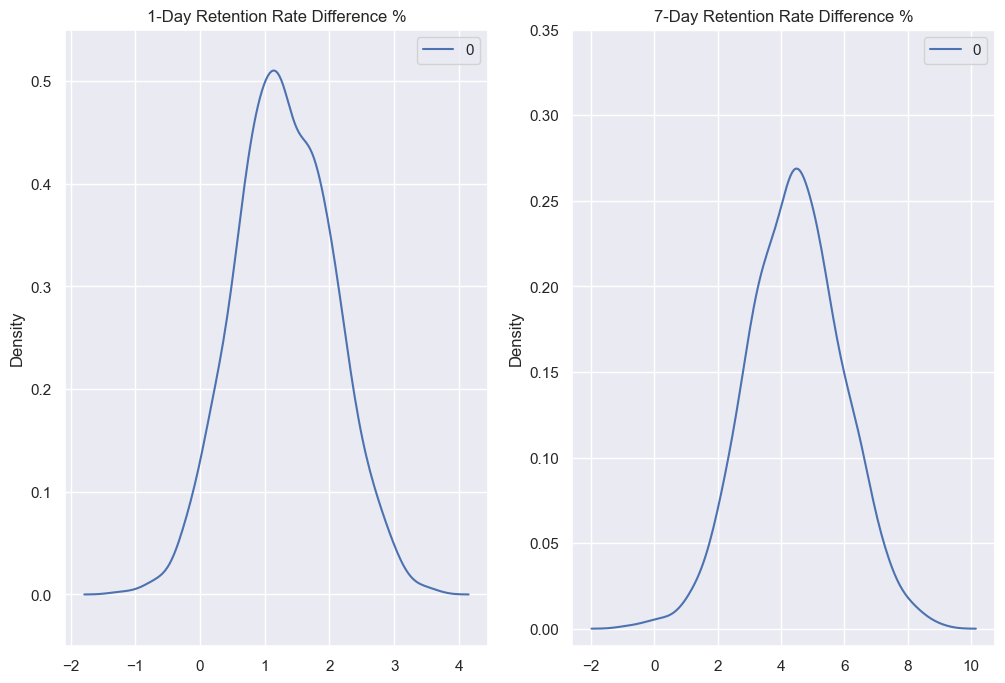

In [150]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
ax1 = sns.kdeplot(boot_1d_diff)
ax1.set_ylim(-0.05, 0.55)
plt.title("1-Day Retention Rate Difference %")


plt.subplot(1, 2, 2) # index 2
ax2 = sns.kdeplot(boot_7d_diff)
ax2.set_ylim(-0.01, 0.35)
plt.title("7-Day Retention Rate Difference %")

plt.show()

In [119]:
(boot_1d_diff > 0).mean()

0    0.959
dtype: float64

## 5. Conclusion <a name= '5'></a>

<p>We use three methods ,and the results tell us that <strong>there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.</strong> The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40.</p>